### Setup for Google Collab

In [0]:
# kill virtual machine and restart
!kill -9 -1

In [1]:
! pip install tqdm
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install -q keras

    100% |████████████████████████████████| 61kB 2.9MB/s 


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def save_to_drive(file_name, file_path): 
  file1 = drive.CreateFile()
  file1['title'] = file_name
  file1.SetContentFile(file_path)
  file1.Upload()
  print('title: %s, mimeType: %s' % (file1['title'], file1['mimeType']))

# From: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)   

In [124]:
file_id = '11H5PmaoAabAoID79E7MlPYoAKo2ivdEY'
destination = './data.zip'
download_file_from_google_drive(file_id, destination)
! unzip data.zip
! rm data/stage1_train/test_data # why is this here?

file_id = '1WJCjN_aDnkyI8hK5Euoi60UAqCsTxR66'
destination = './SegDataGenerator.py'
download_file_from_google_drive(file_id, destination)

file_id = '1RzcMW8hFvdEKflQ8xdmisJButpXZ1s7r'
destination = './dataset_256x256.npz'
download_file_from_google_drive(file_id, destination)

UnboundLocalError: ignored

In [0]:
# https://stackoverflow.com/questions/1668223/how-to-de-import-a-python-module
def delete_module(modname, paranoid=None):
    from sys import modules
    try:
        thismod = modules[modname]
    except KeyError:
        raise ValueError(modname)
    these_symbols = dir(thismod)
    if paranoid:
        try:
            paranoid[:]  # sequence support
        except:
            raise ValueError('must supply a finite list for paranoid')
        else:
            these_symbols = paranoid[:]
    del modules[modname]
    for mod in modules.values():
        try:
            delattr(mod, modname)
        except AttributeError:
            pass
        if paranoid:
            for symbol in these_symbols:
                if symbol[:2] == '__':  # ignore special symbols
                    continue
                try:
                    delattr(mod, symbol)
                except AttributeError:
                    pass

In [0]:
file_id = '1WJCjN_aDnkyI8hK5Euoi60UAqCsTxR66'
destination = './SegDataGenerator.py'
download_file_from_google_drive(file_id, destination)

In [0]:
delete_module('SegDataGenerator')

In [0]:
!rm -rf SegDataGenerator.py

In [126]:
!ls

data	 dataset_256x256.npz	 data.zip  model	SegDataGenerator.py
datalab  dataset_256x256.npz.py  __MACOSX  __pycache__


# Setup

[U-Net](https://arxiv.org/abs/1505.04597)

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

%matplotlib inline

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
# seed = 42
# random.seed = seed
# np.random.seed = seed

from SegDataGenerator import SegDataGenerator

In [0]:
# Utility function for plotting multiple images
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(np.squeeze(imgs[i]), cmap='gray')

# Get the data

Dataset structure:

* stage1_train/
    * folders for each image
        * images/ : contains one png (not multiple, but then why is this called "images" plural?; see check below)
        * masks/ : individual png masks for each cell 
        
Ideally we won't just put masks on top of each other (e.g. with `max`) to get a single mask image, since we will lose borders between cells if we do this). We need to do some background pixel insertion + weighting, like in U-net paper. 

In [0]:
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

# Should image be larger? What's the range of image sizes in dataset (see exploration kernels)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Note: this assumes that dataset is already solved to npz (by data_preprocessing notebook)
def load_raw_data(data_path, image_size=(256, 256)):
    print('Reading from previously loaded data.')
    npzfile = np.load(data_path)
    return npzfile['X_train'], npzfile['Y_train'], npzfile['C_train'], npzfile['W_train'], npzfile['X_test']

In [28]:
X_train, Y_train, _, _, X_test = load_raw_data('dataset_256x256.npz', image_size=(IMG_HEIGHT, IMG_WIDTH))

Reading from previously loaded data.


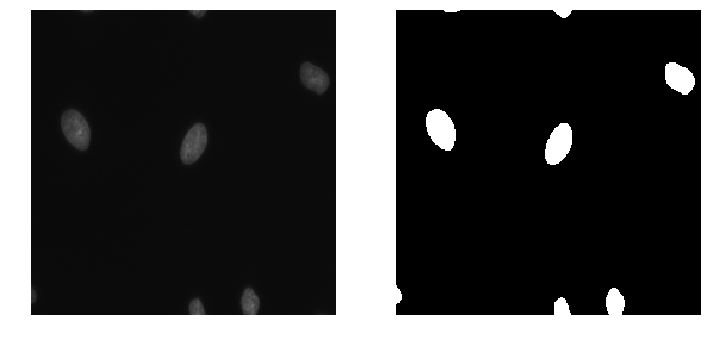

In [24]:
idx = random.randint(1, X_train.shape[0])
plots([X_train[idx], Y_train[idx]])

### Define and train U-net model

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
# model.summary()

In [0]:
# Weighted loss function model with weighted loss function

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation=None) (c9)

# work-around for keras' output vs label dim checking - pad output with a layer of garbage
# putting constant of zeros in might be better...
hack_image = Conv2D(1, (1, 1))(inputs)
outputs_hack = concatenate([outputs, hack_image], axis=3)

model = Model(inputs=[inputs], outputs=[outputs_hack])

# remove sigmoid activation on last layer if using this
def pixelwise_weighted_cross_entropy_loss(y_true, y_pred):
    
    pred = tf.gather(y_pred, [0], axis=3)
    mask = tf.gather(y_true, [0], axis=3)
    weights = tf.gather(y_true, [1], axis=3)
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=mask, 
                                   logits=pred,
                                   weights=weights)
    return loss

model.compile(optimizer='adam', loss=pixelwise_weighted_cross_entropy_loss, metrics=[mean_iou])

# model.summary()

In [96]:
# Make sure use_weights works
trainGenerator = SegDataGenerator(horizontal_flip=False, vertical_flip=False,
                                   featurewise_center=False, featurewise_std_normalization=False,
                                   elastic_transform=False, rotation_right=False)

train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
                                               class_mode='segmentation', color_mode='rgb',
                                               use_weights=True, label_bw=True)

images, labels = next(train_data)
print(images.shape, labels.shape)
plots([images[0], labels[0][:, :, 0], labels[0][:, :, 1]])
weights = labels[0][:, :, 1]
print(np.min(weights), np.max(weights))

Reading from previously loaded data.
Found 669 images belonging to 2 classes.


In [98]:
data_path = './dataset_256x256.npz'
model_path = 'models'
batch_size = 4
epochs=5
steps_per_epoch=250
validation_step=10

trainGenerator = SegDataGenerator(validation_split=0.2, 
                                   horizontal_flip=False, vertical_flip=False,
                                   featurewise_center=False, featurewise_std_normalization=False,
                                   elastic_transform=True, rotation_right=False)
                                 
# trainGenerator.fit(X_train)

# trainGenerator = SegDataGenerator(validation_split=0.2, width_shift_range=0.02,
#                                    height_shift_range=0.02, zoom_range=0.1,
#                                    horizontal_flip=True, vertical_flip=True,
#                                    featurewise_center=False, featurewise_std_normalization=False,
#                                    elastic_transform=True, rotation_right=True)


# train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
#                                                class_mode='segmentation', color_mode='rgb',
#                                                use_contour=False, label_bw=True)
# val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
#                                               class_mode='segmentation', color_mode='rgb', 
#                                               use_contour=False, label_bw=True)


train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
                                               class_mode='segmentation', color_mode='rgb',
                                               use_weights=True, label_bw=True)
val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                              class_mode='segmentation', color_mode='rgb', 
                                              use_weights=True, label_bw=True)

print("made data generators!")

Reading from previously loaded data.
Found 535 images belonging to 2 classes.
Reading from previously loaded data.
Found 134 images belonging to 2 classes.
made data generators!


((4, 256, 256, 3), (4, 256, 256, 1))

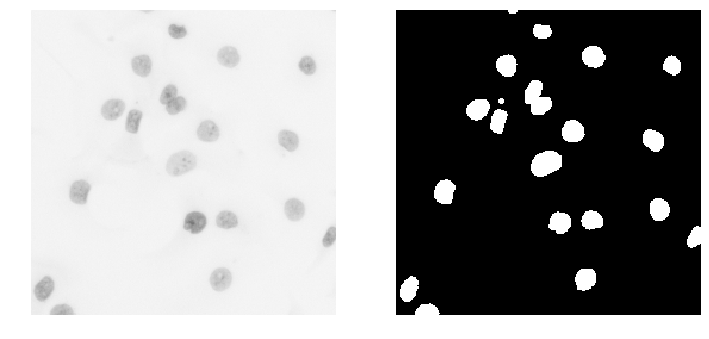

In [49]:
images, labels = next(train_data)
plots([images[0], labels[0]])
images.shape, labels.shape

In [99]:
if not os.path.exists(model_path):
    os.makedirs(model_path)
checkpoint = ModelCheckpoint(model_path+'weight.{epoch:02d}.hdf5', monitor='val_loss',
                             mode='min', period=1)
earlystopper = EarlyStopping(patience=5, verbose=1)

model.fit_generator(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                    callbacks=[earlystopper, checkpoint], validation_data=val_data, 
                    validation_steps=validation_step, shuffle=True)

Epoch 1/5
250/250 [==============================] - 117s 469ms/step - loss: 0.0018 - mean_iou: 0.2250 - val_loss: 8.3284e-04 - val_mean_iou: 0.2285
Epoch 2/5
250/250 [==============================] - 112s 449ms/step - loss: 6.3577e-04 - mean_iou: 0.2385 - val_loss: 5.4206e-04 - val_mean_iou: 0.2459
Epoch 3/5
 33/250 [==>...........................] - ETA: 1:13 - loss: 5.1898e-04 - mean_iou: 0.2469

250/250 [==============================] - 112s 446ms/step - loss: 5.5285e-04 - mean_iou: 0.2501 - val_loss: 4.8159e-04 - val_mean_iou: 0.2533
Epoch 4/5
250/250 [==============================] - 112s 447ms/step - loss: 5.1314e-04 - mean_iou: 0.2556 - val_loss: 5.0288e-04 - val_mean_iou: 0.2573
Epoch 5/5
 48/250 [====>.........................] - ETA: 1:14 - loss: 5.1404e-04 - mean_iou: 0.2575

250/250 [==============================] - 112s 449ms/step - loss: 4.7933e-04 - mean_iou: 0.2585 - val_loss: 5.1737e-04 - val_mean_iou: 0.2598


{'val_loss': [0.12256284952163696, 0.1118578027933836, 0.14030663929879666, 0.10434072203934193, 0.11065667346119881], 'val_mean_iou': [0.6626430749893188, 0.7323434531688691, 0.7592110812664032, 0.7738972246646881, 0.7826276421546936], 'loss': [0.20533071300070846, 0.10641020271662358, 0.09788350637258594, 0.09361778783475708, 0.0943999459838366], 'mean_iou': [0.5566049229525373, 0.7036534576444654, 0.747763694468568, 0.7669096065905385, 0.7783395827592194]}


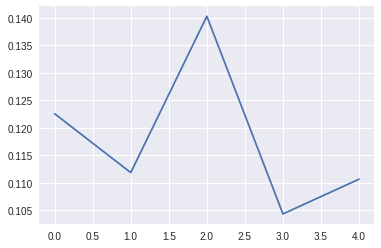

In [87]:
print(model.history.history)
hist = model.history.history
plt.plot(hist['val_loss'])

Performance log: 

batch_size = 4, epochs=5, steps_per_epoch=250, validation_step=10

* no data augmentation: loss: 0.0693, mean_iou: 0.7814, val_loss: 0.0674, val_mean_iou: 0.7854 (**try again with reset**)
* elastic deformation: loss: 0.0944, mean_iou: 0.7783, val_loss: 0.1107, val_mean_iou: 0.7826
* featurewise_center and std_normalization: 
* elastic deformation, flips and rotations: loss: 0.1039, mean_iou: 0.7097, val_loss: 0.1033, val_mean_iou: 0.7177
* elastic deformation, featurewise, flips and rotations: 

---

* standard ImageDataGenerator augmentation without centering/normalization (different training params from currenct settings) -  loss: 0.0751, mean_iou: 0.8552, val_loss: 0.0659, val_mean_iou: 0.8554

# Make predictions

In [0]:
save_to_drive('unet_baseline_256.h5', 'unet_baseline.h5')

title: unet_baseline_256.h5, mimeType: application/octet-stream


In [104]:
# Predict on train, val and test
# model_path = 'unet_baseline.h5'
# model = load_model(model_path, custom_objects={'mean_iou': mean_iou})

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions - TODO figure out what happens without this
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 1s 9ms/step


In [0]:
# remove garbage layer when using weights
preds_train = preds_train[:, :, :, 0]
preds_val = preds_val[:, :, :, 0]
preds_test = preds_test[:, :, :, 0]

preds_train_t = preds_train_t[:, :, :, 0]
preds_val_t = preds_val_t[:, :, :, 0]
preds_test_t = preds_test_t[:, :, :, 0]

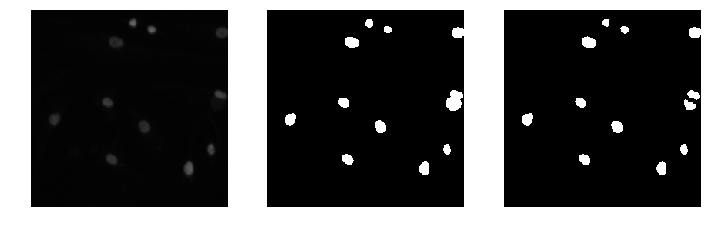

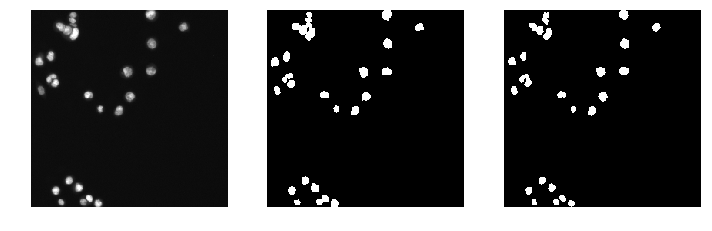

In [119]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plots([X_train[ix], np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix])])

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plots([X_train[int(X_train.shape[0]*0.9):][ix], 
       Y_train[int(Y_train.shape[0]*0.9):][ix], 
       preds_val_t[ix]])

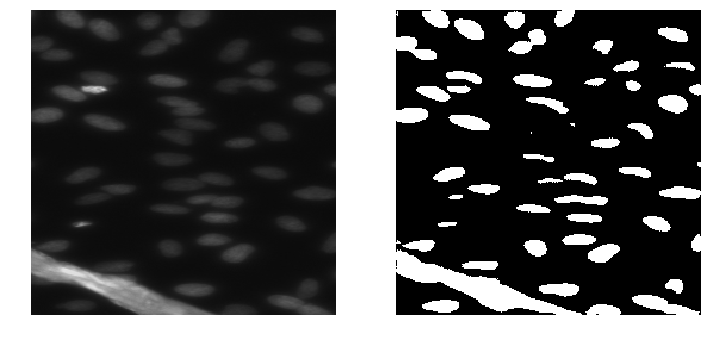

In [125]:
# Try on test set
ix = random.randint(0, len(preds_test_t))
plots([X_test[ix], preds_test_t[ix]])

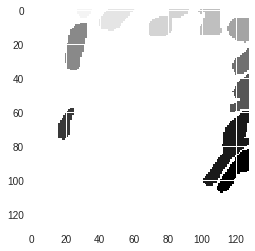

In [0]:
# Analysis from:
# https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies

# TODO figure out how to find borders between cells and give them high weights
# TODO figure out how to plot all labels in different colors

from scipy import ndimage
from matplotlib.colors import ListedColormap

ix = 57
img = X_train[int(X_train.shape[0]*0.9):][ix]
mask = Y_train[int(Y_train.shape[0]*0.9):][ix]
pred_mask = preds_val_t[ix]
# plt.imshow(np.squeeze(mask))

labels, nlabels = ndimage.label(mask)
colors = [int(i % 23 + 1) for i in range(nlabels)]

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)
    
# plt.imshow(np.squeeze(labels)) #, cmap=cmap)

# Prune tiny objects
label_ind_coords = ndimage.find_objects(labels)

for label_ind, label_coords in enumerate(label_ind_coords):
    cell = mask[label_coords]
    plt.imshow(np.squeeze(cell))
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)

plt.imshow(np.squeeze(labels)) #, cmap=cmap)

TypeError: ignored

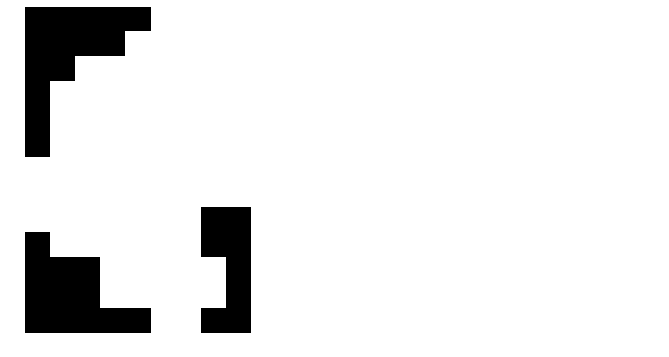

In [0]:
two_cell_indices = ndimage.find_objects(labels)[8]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=1)
plots([np.squeeze(cell_mask), cell_mask_opened])

In [0]:
# IoU computation for numpy arrays
# Based on https://gist.github.com/meetshah1995/6a5ad112559ef1536d0191f8b9fe8d1e

def computeIoU(y_pred_batch, y_true_batch):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i]) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred, y_true):
    shape = y_pred.shape
    y_pred = np.squeeze(y_pred)
    y_true = np.squeeze(y_true)
    y_pred = y_pred * (y_true>0)
    
    if np.sum(y_true>0) == 0:
        print('wtf')
    
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  np.sum(y_true>0)
  
Y_val = Y_train[int(Y_train.shape[0]*0.9):].astype(np.uint8)
val_mean_iou = computeIoU(Y_val, preds_val_t.astype(np.uint8))
print(val_mean_iou)

0.893623834452473


# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Basic idea: we need to encode each label_mask into a "run line encoded" string. Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-2.csv', index=False)

In [0]:
!ls

data	 data.zip  model-dsbowl2018-1.h5  sub-dsbowl2018-1.csv
datalab  __MACOSX  model-dsbowl2018-2.h5  sub-dsbowl2018-2.csv


In [0]:
save_to_drive('model-dsbowl2018-2.h5', 'model-dsbowl2018-2.h5')
save_to_drive('sub-dsbowl2018-2.csv', 'sub-dsbowl2018-2.csv')

title: model-dsbowl2018-2.h5, mimeType: application/octet-stream
title: sub-dsbowl2018-2.csv, mimeType: text/csv


This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example). Version 7 scores 0.277!

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB